In [2]:
import os
import numpy as np
import pandas as pd
import warnings

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [6]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [7]:
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
warnings.filterwarnings("ignore")

In [8]:
train_path = "./Dataset/preprocess_Loan.csv"

In [9]:
data = pd.read_csv(train_path)
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,146.0,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [10]:
print(f"training set (row, col): {data.shape}")

training set (row, col): (614, 13)


In [11]:
data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             614 non-null    object 
 2   Married            614 non-null    object 
 3   Dependents         614 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      614 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         614 non-null    float64
 9   Loan_Amount_Term   614 non-null    float64
 10  Credit_History     614 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [12]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,146.397394,342.410423,0.855049
std,6109.041673,2926.248369,84.037503,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,129.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [13]:
data.drop('Loan_ID',axis=1,inplace=True)
print(f"training set (row, col): {data.shape}")

training set (row, col): (614, 12)


In [14]:
data.isnull().sum().sort_values(ascending=False)

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [15]:
print("Before filling missing values\n\n","#"*50,"\n")
null_cols = ['Credit_History', 'Self_Employed', 'LoanAmount','Dependents', 'Loan_Amount_Term', 'Gender', 'Married']


for col in null_cols:
    print(f"{col}:\n{data[col].value_counts()}\n","-"*50)
    data[col] = data[col].fillna(
    data[col].dropna().mode().values[0] )   

    
data.isnull().sum().sort_values(ascending=False)
print("After filling missing values\n\n","#"*50,"\n")
for col in null_cols:
    print(f"\n{col}:\n{data[col].value_counts()}\n","-"*50)

Before filling missing values

 ################################################## 

Credit_History:
1.0    525
0.0     89
Name: Credit_History, dtype: int64
 --------------------------------------------------
Self_Employed:
No     532
Yes     82
Name: Self_Employed, dtype: int64
 --------------------------------------------------
LoanAmount:
146.0    23
120.0    20
110.0    17
100.0    15
160.0    12
         ..
54.0      1
78.0      1
436.0     1
207.0     1
253.0     1
Name: LoanAmount, Length: 203, dtype: int64
 --------------------------------------------------
Dependents:
0     360
1     102
2     101
3+     51
Name: Dependents, dtype: int64
 --------------------------------------------------
Loan_Amount_Term:
360.0    526
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64
 --------------------------------------------------
Gender:
Male      502
Female    112
Name: Gender, dtype

In [16]:
num = data.select_dtypes('number').columns.to_list()
cat = data.select_dtypes('object').columns.to_list()
loan_num =  data[num]
loan_cat = data[cat]

Y    422
N    192
Name: Loan_Status, dtype: int64


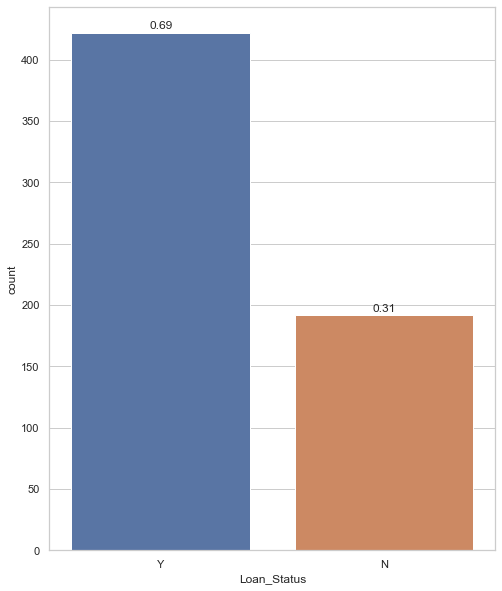

In [17]:
print(data[cat[-1]].value_counts())
total = float(len(data[cat[-1]]))
plt.figure(figsize=(8,10))
sns.set(style="whitegrid")
ax = sns.countplot(data[cat[-1]])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.2f}'.format(height/total),ha="center") 
plt.show()

In [18]:
to_numeric = {'Male': 1, 'Female': 2,
'Yes': 1, 'No': 2,
'Graduate': 1, 'Not Graduate': 2,
'Urban': 3, 'Semiurban': 2,'Rural': 1,
'Y': 1, 'N': 0,
'3+': 3}
data = data.applymap(lambda lable: to_numeric.get(lable) if lable in to_numeric else lable)
Dependents_ = pd.to_numeric(data.Dependents)
data.drop(['Dependents'], axis = 1, inplace = True)
data = pd.concat([data, Dependents_], axis = 1)
print(f"training set (row, col): {data.shape}")
print(data.info())

training set (row, col): (614, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Education          614 non-null    int64  
 3   Self_Employed      614 non-null    int64  
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         614 non-null    float64
 7   Loan_Amount_Term   614 non-null    float64
 8   Credit_History     614 non-null    float64
 9   Property_Area      614 non-null    int64  
 10  Loan_Status        614 non-null    int64  
 11  Dependents         614 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 57.7 KB
None


<AxesSubplot:>

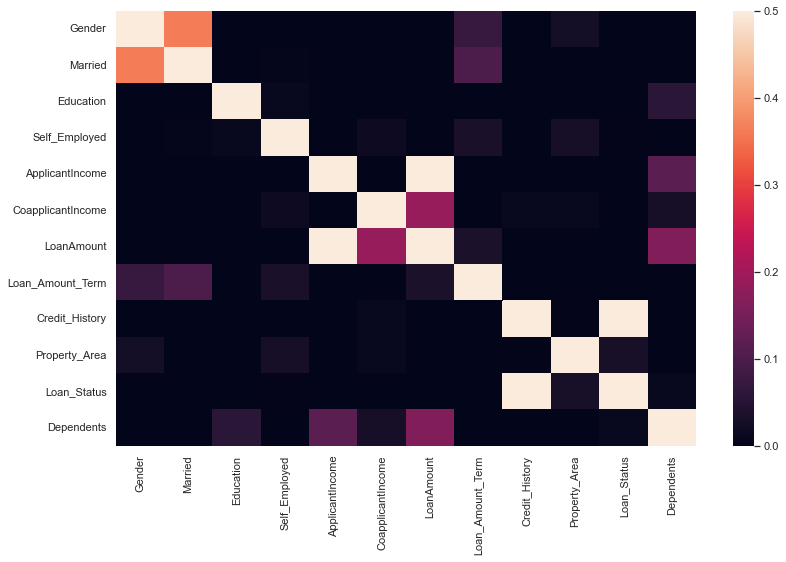

In [19]:
plt.subplots(figsize=(13,8))
sns.heatmap(data.corr(), vmin=0, vmax=0.5)

In [143]:
y = data['Loan_Status']
X = data.drop('Loan_Status', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.38, random_state = 0)

In [144]:
X_train.head()

,Gender,Married,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Dependents
137,1,1,1,1,3316,3500.0,88.0,360.0,1.0,3,2
330,1,2,1,2,4384,1793.0,117.0,360.0,1.0,3,1
7,1,1,1,2,3036,2504.0,158.0,360.0,0.0,2,3
483,1,1,1,2,10833,0.0,234.0,360.0,1.0,2,0
179,1,2,2,2,2333,1451.0,102.0,480.0,0.0,3,0


In [145]:
X_train.dtypes

Gender                 int64
Married                int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Dependents             int64
dtype: object

In [146]:
y_train

137    1
330    1
7      0
483    1
179    0
      ..
277    1
9      0
359    1
192    0
559    1
Name: Loan_Status, Length: 380, dtype: int64

In [147]:
DT = DecisionTreeClassifier(max_depth=98)
DT.fit(X_train, y_train)
y_predict = DT.predict(X_test)
print(classification_report(y_test, y_predict))
DT_SC = accuracy_score(y_predict,y_test)
print(f"{round(DT_SC*100,2)}% Accurate")

              precision    recall  f1-score   support

           0       0.48      0.46      0.47        69
           1       0.78      0.79      0.78       165

    accuracy                           0.69       234
   macro avg       0.63      0.63      0.63       234
weighted avg       0.69      0.69      0.69       234

69.23% Accurate


In [148]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 55, metric = 'minkowski', p = 2)
knn.fit(X_train, y_train)
Y_pred_knn = knn.predict(X_test)
KNN_SC = accuracy_score(y_test, Y_pred_knn)
print(KNN_SC)

0.7051282051282052


In [149]:
['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

In [150]:
logmodel = LogisticRegression(solver='sag')
logmodel.fit(X_train, y_train)
y_predict = logmodel.predict(X_test)
print(classification_report(y_test, y_predict))
LR_SC = accuracy_score(y_predict,y_test)
print('accuracy is',accuracy_score(y_predict,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        69
           1       0.71      1.00      0.83       165

    accuracy                           0.71       234
   macro avg       0.35      0.50      0.41       234
weighted avg       0.50      0.71      0.58       234

accuracy is 0.7051282051282052


In [151]:
score = [DT_SC,LR_SC,KNN_SC]
Models = pd.DataFrame({
    'n_neighbors': ["Decision Tree","Logistic Regression", "KNN"],
    'Score': score})
Models.sort_values(by='Score', ascending=False)

,n_neighbors,Score
1,Logistic Regression,0.705128
2,KNN,0.705128
0,Decision Tree,0.692308


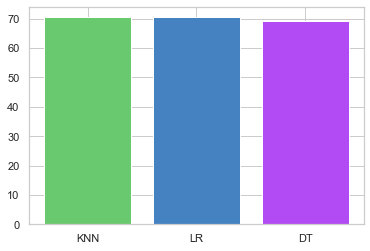

In [152]:
KNN = KNN_SC * 100
LR=LR_SC * 100
DT=DT_SC* 100
height = [KNN,LR,DT]
bars = ( 'KNN', 'LR','DT')
x_pos = np.arange(len(bars))
plt.bar(x_pos, height, color=['#69C96E', '#4482C1', '#B24BF3'])
plt.xticks(x_pos, bars)
plt.show()

In [153]:
import pickle
KNN_model_path = "./Trained_Model/model.pkl"
with open(KNN_model_path, 'wb') as file:
    pickle.dump(knn, file)
print("Model successfully completed......!")

Model successfully completed......!
